# 基于MindSpore框架的MASS案例实现
## 1 模型简介
微软亚洲研究院于2019在ICML发表《MASS: Masked Sequence to Sequence Pre-training for Language Generation》，其借鑑了Bert的Masked Language Model预训练任务，提出了MAsked Sequence to Sequence Pre-training（MASS）模型，为自然语言生成任务联合预训练编码器和解码器。

MASS的编码器-解码器结构示例，图中“_”表示被屏蔽的词。

<center>
<img src='https://i.imgur.com/Jvhm0Dx.png' width='600px'>
</center>

编码器： 以被随机屏蔽掉连续片段的句子作为输入，BERT的做法是随机屏蔽掉15%的词，而MASS为了解决编码与解码之间的平衡，做法为屏蔽掉句子总长50%的片段。模型中使用特殊符号$[\mathbb M]$替换连续的单词来屏蔽片段，起始位置是随机的，且被选中的token有80%的概率是正常的$[\mathbb M]$token，10%的概率是被随机token替换，10%的概率保持原来的token。以上图为例，其中输入序列有8个单词，片段$x_3-x_6$被屏蔽掉。

解码器：输入为与编码器同样的序列，但是会屏蔽掉剩馀的词，然后解码器只预测编码器端屏蔽掉的词。以上图为例，只给定 $x_3x_4x_5$ 作为位置 4 - 6 的解码器输入，解码器会将 $[\mathbb M]$ 作为其他位置的输入（屏蔽了位置 1 − 3 和 7 − 8）。为了减少内存和计算成本，被屏蔽的token会被移除，未屏蔽token的位置编码不变（如果前两个标记被屏蔽并移除，第三个标记的位置仍然是 2 而不是 0)。通过这种方式，可以获得相似的准确度，并在解码器中减少 50% 的计算量。


```
encoder input (source): [x1, x2, x3, x4, x5, x6, x7, x8, </eos>]
masked encoder input:   [x1, x2, x3,  _,  _,  _, x7, x8, </eos>]
decoder input:          [  -, x3, x4, x5]
                          |   |   |   |
                          V   V   V   V
decoder output:         [x3, x4, x5, x6]
```

MASS预训练有以下几大优势：

(1) 编码器被强制去抽取未被屏蔽掉的词的含义，可以提升编码器理解源序列文本的能力。<br>
(2) 通过在解码器端预测连续的标记，解码器可以比仅预测离散标记拥有更好的语言建模能力。<br>
(3) 通过在解码器端进一步屏蔽在编码器端未被屏蔽掉的词， 以鼓励解码器从编码器端提取更多有用的信息来做预测，而不是依赖于前面预测出的单词，这样能促进编码器-解码器结构的联合训练。

### 1.1 模型结构

其模型基础结构可以使用任何Seq2Seq的结构，由于Transformer的优越性，故论文中使用Transformer模型作为基础结构，Transformer整体架构由编码器和解码器两个部分组成，不依赖任何RNN和CNN结构来生成输出，而是使用了Attention注意力机制，自动学习输入序列中每个单词和其他单词的关联，可以更好的处理长文本，且该模型可以高效的并行工作，训练速度较快。

Transformer 的整体架构如下：

<center>
<img src='https://i.imgur.com/ooO7ULP.png' width='400px'>
</center>

- 编码器和解码器分别由$N=6$个相同的编码器/解码器层组成。
- 在 Transformer 架构的左半部分，编码器的任务是将输入序列映射到一系列连续表示，然后将其馈送到解码器。
- 架构右半部分的解码器接收编码器的输出以及前一个时间步的解码器输出，以生成输出序列。
- 解码器的输出最终通过一个全连接层，然后是一个 softmax 层，以生成对输出序列下一个单词的预测。

### 1.2目标函数

给定一个未配对的源句子$x ∈ \mathcal X$，MASS通过被屏蔽的序列$x^{\setminus u:v}$作为输入来预测句子片段$x^{u:v}$以预训练序列到序列模型。目标函数为一极大似然函数：

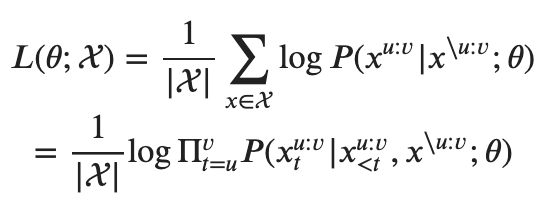

注: $x^{u:v}$表示以句子位置$u$为起点$v$为终点的片段；$x^{\setminus u:v}$为$x^{u:v}$的修改版本，从$u$到$v$的片段被屏蔽，$0 < u < v < m$ 其中 $m$ 是句子 $x$ 长度。

### 1.3 模型特点
MASS 有一个重要的超参数 $k$，表示屏蔽的连续片段长度，通过调整 $k$ 的大小，MASS 能包含 BERT 中的掩码语言模型训练方法以及 GPT 中标准的语言模型预训练方法，使 MASS 成为一个通用的预训练框架。

当 $k = 1$ 时，根据MASS的设定，编码器端仅屏蔽一个单词，解码器以源序列中未屏蔽的单词为条件预测这个单词，如图(a)所示。由于解码器的所有输入都被屏蔽了，因此解码器本身就像一个非线性分类器，类似于 BERT 中使用的 softmax 矩阵。在这种情况下，条件概率为 $P (x^u|x^{\setminus u}; θ)$，$u$是掩码标记的位置，这正是 BERT3中使用的掩码语言模型的公式。

当 $k = m$（ $m$ 为序列长度）时，根据MASS的设定，编码器会屏蔽所有的单词，解码器需要预测所有单词，如图(b)所示。由于编码器端所有词都被屏蔽了，解码器的注意力机制相当于没有获取到信息，在这种情况下条件概率为 $P(x^{1:m}|x^{\setminus 1:m}; θ)$，等价于GPT中的标准语言模型。


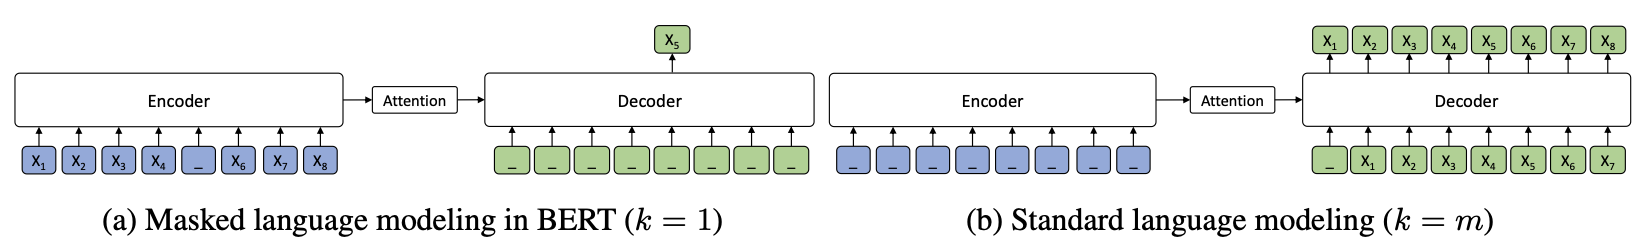

## 2 案例实现

### 2.1 环境建置
本案例的开发环境为Modelarts上的notebook。<br>
版本：mindspore 1.8.1 python 3.7<br>
Ascend 环境：1\*Ascend 910 | CPU: 24vCPUs 96GB<br>

In [5]:
import mindspore
print(mindspore.run_check())

MindSpore version:  1.8.1
The result of multiplication calculation is correct, MindSpore has been installed successfully!
None


进入开发环境后还需安装一些所需套件，执行以下命令即可：

In [ ]:
!pip install -r requirements.txt

In [2]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/ma-user/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

### 2.2 准备数据集
案例实现中预训练所使用的数据即News Crawl的英语单语数据数据集，因为考量到训练模型所需时间，只使用2012年的数据(News Crawl: articles from 2012)，下载好的数据集为一纯文字文件，接下来需要对该数据进行预处理，预处理包括对数据进行分词、利用subword-nmt工具生成字节对编码(BPE)、对分词后的语料应用该BPE编码进行切分并构建词彙表几个步骤。

而微调模型用于文本摘要任务所使用的数据集为Gigaword，该数据集已经有分割为训练、测试、验证集，有原文本(src)和目标摘要(tgt)两个文件，本案例只会使用训练集与测试集，也需要对这两个文件进行同样的预处理。

数据集文件路径结构如下：

.dataset/<br>
└── news_crawl<br>
&emsp;&ensp;└── news2012.txt(1.8GB)<br>
└── ggw_data<br>
&emsp;&ensp;├── test.src.txt(335KB)<br>
&emsp;&ensp;├── test.tgt.txt(104KB)<br>
&emsp;&ensp;├── train.src.txt(695.2MB)<br>
&emsp;&ensp;└── train.tgt.txt(198.5MB)<br>

下载连接：<br>
News Crawl数据集（WMT，2019年）：https://www.statmt.org/wmt16/translation-task.html<br>
Gigaword语料库（Graff等人，2003年）： https://drive.google.com/open?id=0B6N7tANPyVeBNmlSX19Ld2xDU1E



#### 2.2.1 对原始数据进行分词

文本是由段落（Paragraph）构成的，段落是由句子（Sentence）构成的，句子是由单词构成的。分词是文本分析的第一步，它把文本段落分解为较小的实体（如单词或句子），每一个实体叫做一个Token。NLTK套件能够实现句子切分和单词切分两种功能。

因为原始数据是一行一行句子的格式，所以只要调用nltk套件中的word_tokenize()函数文本进行分词，此函数的作用是基于空格/标点等对文本进行分词，返回分词后的列表，最后只保留长度大于175的单词列表，并将这些单词列表写入目标文件中。

```
sen = "Dave Aneckstein, Simmons Research, an Experian Company"
tokens = word_tokenize(sen)
tokens = ['Dave', 'Aneckstein', ',', 'Simmons', 'Research', ',', 'an', 'Experian', 'Company']
```





In [3]:
import os
from nltk.tokenize import word_tokenize

data_list = ['news_crawl', 'ggw_data']
src_folder = "./dataset/"
out_folder = "./tokenized_corpus/"

def create_tokenized_sentences(file_path, tokenized_file):
    tokenized_sen = []
    print(f" | Processing {file_path}.")
    with open(file_path, "r") as file:
        for sen in file:
            tokens = word_tokenize(sen)
            tokens = [t for t in tokens if t != " "]
            if len(tokens) > 175:
                continue
            tokenized_sen.append(" ".join(tokens) + "\n")

    with open(tokenized_file, "w") as file:
        file.writelines(tokenized_sen)
    print(f" | Wrote to {tokenized_file}.")

for item in data_list:
    folder_path = os.path.join(src_folder, item)
    output_path = os.path.join(out_folder, item)
    for file in os.listdir(folder_path):
        if not file.endswith(".txt"):
            continue
        file_path = os.path.join(folder_path, file)
        tokenized_file = os.path.join(output_path, file.replace(".txt", "_tokenized.txt"))
        create_tokenized_sentences(file_path, tokenized_file)

 | Processing ./dataset/news_crawl/news2012.txt.
 | Wrote to ./tokenized_corpus/news_crawl/news2012_tokenized.txt.
 | Processing ./dataset/ggw_data/test.src.txt.
 | Wrote to ./tokenized_corpus/ggw_data/test.src_tokenized.txt.
 | Processing ./dataset/ggw_data/train.src.txt.
 | Wrote to ./tokenized_corpus/ggw_data/train.src_tokenized.txt.
 | Processing ./dataset/ggw_data/train.tgt.txt.
 | Wrote to ./tokenized_corpus/ggw_data/train.tgt_tokenized.txt.
 | Processing ./dataset/ggw_data/test.tgt.txt.
 | Wrote to ./tokenized_corpus/ggw_data/test.tgt_tokenized.txt.


#### 2.2.2 生成字节对编码
虽然我们已经将数据进行了简单的分词，但是实际上这样的分词是不够细緻的，若要使用一个包含所有单词的字典，将需要很大的空间和计算量，而且过大的token列表也会影响模型的预测准确度。

字节对编码（BPE, Byte Pair Encoder）是一种简单的数据压缩算法，它将字符串中出现频率最高的相邻字符替换成一个不存在的新字符，反复进行该操作直到满足某些预设条件为止（字符表大小、迭代次数）。后续使用时还需要一个词表来重建原始数据。

BPE的处理过程可以理解为一个单词的再拆分过程。如"loved","loving","loves"这三个单词，其本身的语义都是”爱”的意思。BPE通过训练，能够把上面的3个单词拆分成”lov”,”ed”,”ing”,”es”几部分，这样可以把词的本身的意思和时态分开，有效的减少了词表大小，且罕见的词会被分解为两个或多个subword tokens，能比较好的处理OOV(out of vocabulary)问题。

我们可以利用subword-nmt工具学习文本的字节对编码(learn-bpe)：

先设定选择最高频字节对的次数num_operations，本案例设定为46000。此过程会统计每一个相邻字节对的出现频率，并保存为code_file。
```
subword-nmt learn-bpe -i {input_src_file} -s {num_operations} -o {codes_file}
```


In [4]:
!cat ./dataset/ggw_data/*.txt ./dataset/news_crawl/*.txt | subword-nmt learn-bpe -s 46000 -o ./dataset/all.bpe.codes

100%|#####################################| 46000/46000 [41:34<00:00, 18.44it/s]


#### 2.2.3 应用字节对编码并构建词彙表
使用上一节获取的BPE编码对分词后的语料进行字节对编码处理(apply-bpe)，生成subword词表。此过程会将input_tokenized_file中的单词拆分为字符序列并在末尾添加后缀“<\/w>”，而后按照code_file将出现频率最高的字节对合并成新的subword，重複合併直到达到设定的subword词表大小或下一个最高频的字节对出现频率为1，最后将结果保存为out_file，文件名为input_tokenized_file_bpe.txt。
```
subword-nmt apply-bpe -c {code_file} < {input_tokenized_file} > {out_file}
可以通过 --vocabulary-threshold {threshold} 选项过滤词频低于阈值的单词来缩小词汇量。
```
构建词彙表(get-vocab)的具体作法为：得到subword词表后，对该词表按照子词长度由大到小排序。编码时，对于每个单词，遍历词表寻找是否有token是当前单词的子字符串，如果有，则该token为表示当前单词的tokens之一。从最长的token迭代到最短的token，尝试将每个单词中的子字符串替换为已存在的token。若每个单词都替换完后仍然有子字符串没被替换，则将剩余的子词替换为特殊token，如\<unk>。
```
subword-nmt get-vocab -i {output_path} -o {dict_path}
# output_path为apply-bpe的输出路径
# dict_path为输出的.dict档案路径
```

根据News Crawl 2012数据集的14869673个句子，学习到的词汇量为39284个单词。
```
with open('./dataset/news_crawl/news2012.txt', "r") as file:
    count = 0
    for sen in file:
        count+=1
print(count)
```

In [2]:
import os
import subprocess
from src.utils import Dictionary

source_folder = os.path.abspath("./tokenized_corpus/news_crawl/")
output_folder = os.path.abspath("./tokenized_corpus/news_crawl/bpe/")
codes = os.path.abspath("./dataset/all.bpe.codes")
vocab_path = "./vocab/all_en.dict.bin"

ENCODER = "subword-nmt apply-bpe -c"
LEARN_DICT = "subword-nmt get-vocab -i"
def bpe_encode(codes_path, src_path, output_path, dict_path):
    # Encoding.
    print(" | Applying BPE encoding.")
    commands = ENCODER.split() + [codes_path] + ["-i"] + [src_path] + ["-o"] + [output_path]
    subprocess.call(commands)
    print(" | Fetching vocabulary from single file.")
    # Learn vocab.
    commands = LEARN_DICT.split() + [output_path] + ["-o"] + [dict_path]
    subprocess.call(commands)

available_dict = []
for file in os.listdir(source_folder):
    if file.endswith(".txt"):
        output_path = os.path.join(output_folder, file.replace(".txt", "_bpe.txt"))
        dict_path = os.path.join(output_folder, file.replace(".txt", ".dict"))
        available_dict.append(dict_path)
        bpe_encode(codes, os.path.join(source_folder, file), output_path, dict_path)
        
# 加载bpe_encode处理过的文本词汇表，行格式为[word, freq]。
vocab = Dictionary.load_from_text(available_dict)
vocab.persistence(vocab_path) #将词汇表对象保存为二进制文件。
print(f" | Vocabulary Size: {len(vocab)}")

 | Applying BPE encoding.
 | Fetching vocabulary from single file.
 | Vocabulary Size: 39284


### 2.3 生成数据集

因为生成的数据集格式是tfrecord, 这边需要将kernal修改为tensorflow-1.15，再安装mindspore。
并使用以下命令处理下某些套件与tensorflow的冲突。

In [13]:
!pip install mindspore-ascend==1.8.1 rouge
!pip uninstall -y urllib3 chardet
!pip install --upgrade requests
#!pip uninstall -y mindspore

Looking in indexes: http://192.168.0.122:8888/repository/pypi/simple
     |████████████████████████████████| 129.0 MB 64.2 MB/s eta 0:00:01
Found existing installation: urllib3 1.21.1
Uninstalling urllib3-1.21.1:
  Successfully uninstalled urllib3-1.21.1
Found existing installation: chardet 4.0.0
Uninstalling chardet-4.0.0:
  Successfully uninstalled chardet-4.0.0
Looking in indexes: http://192.168.0.122:8888/repository/pypi/simple


In [ ]:
"""Create News Crawl Pre-Training Dataset."""
import os
from src.dataset import MonoLingualDataLoader
from src.language_model import LooseMaskedLanguageModel
from src.utils import Dictionary

input_folder_path = './dataset/news_crawl/' # Raw corpus folder
output_folder_path = './train_data/news_crawl/' # Dataset output path

vocab_path = './vocab/all_en.dict.bin' # Existed vocab path
vocab = Dictionary.load_from_persisted_dict(vocab_path)

def create_pre_train(text_file, output_folder, vocab, max_sen_len):
    
    loader = MonoLingualDataLoader(
        src_filepath=text_file,
        lang="en", dictionary=vocab,
        language_model=LooseMaskedLanguageModel(mask_ratio=0.5, mask_all_prob=None),
        max_sen_len=max_sen_len, min_sen_len=10
    )

    src_file_name = os.path.basename(text_file)

    file_name = os.path.join(
        output_folder_path,
        src_file_name.replace('.txt', f'_len_{max_sen_len}.tfrecord')
    )
    
    loader.write_to_tfrecord(path=file_name)

for file in os.listdir(input_folder_path):
    if file.endswith(".txt"):
        create_pre_train(os.path.join(input_folder_path, file),output_folder_path, vocab, 32)

print(f" | Generate Dataset for Pre-training is done.")
print(f" | Vocabulary size: {vocab.size}.")

 | Processing corpus ./dataset/news_crawl/news2012.txt.
 | Shortest len = 1.
 | Longest  len = 6578.
 | Total    sen = 9981282.
 | Write to /home/ma-user/work/train_data/news_crawl/news2012_len_32.tfrecord-001-of-001.
 | Generate Dataset for Pre-training is done.
 | Vocabulary size: 39284.


In [1]:
"""Generate Gigaword dataset."""
import os
from src.dataset import BiLingualDataLoader
from src.language_model import NoiseChannelLanguageModel
from src.utils import Dictionary

input_folder_path = './dataset/ggw_data/'
output_folder_path = './train_data/ggw_data/'
vocab_path = './vocab/all_en.dict.bin'

vocab = Dictionary.load_from_persisted_dict(vocab_path)

train = BiLingualDataLoader(
    src_filepath=os.path.join(input_folder_path,"train.src.txt"),
    tgt_filepath=os.path.join(input_folder_path,"train.tgt.txt"),
    src_dict=vocab, tgt_dict=vocab,
    src_lang="en", tgt_lang="en",
    language_model=NoiseChannelLanguageModel(add_noise_prob=0.),
    max_sen_len=32
)

train.write_to_tfrecord(
    path=os.path.join(output_folder_path, "gigaword_train_dataset.tfrecord")
)

test = BiLingualDataLoader(
    src_filepath=os.path.join(input_folder_path,"test.src.txt"),
    tgt_filepath=os.path.join(input_folder_path,"test.tgt.txt"),
    src_dict=vocab, tgt_dict=vocab,
    src_lang="en", tgt_lang="en",
    language_model=NoiseChannelLanguageModel(add_noise_prob=0),
    max_sen_len=32
)

test.write_to_tfrecord(
    path=os.path.join(output_folder_path, "gigaword_test_dataset.tfrecord")
)

print(f" | Generate Dataset for fine-tuneing is done.")
print(f" | Vocabulary size: {vocab.size}.")

 | Processing corpus ./dataset/ggw_data/train.src.txt.
 | Processing corpus ./dataset/ggw_data/train.tgt.txt.
 | Shortest len = 3.
 | Longest  len = 100.
 | Total    sen = 1981314.
 | Total token num=87383811, 8.554423198594531% replaced by <unk>.
 | Write to /home/ma-user/work/train_data/ggw_data/gigaword_train_dataset.tfrecord-001-of-001.
 | Processing corpus ./dataset/ggw_data/test.src.txt.
 | Processing corpus ./dataset/ggw_data/test.tgt.txt.
 | Shortest len = 2.
 | Longest  len = 73.
 | Total    sen = 1081.
 | Total token num=46933, 8.011420535657214% replaced by <unk>.
 | Write to /home/ma-user/work/train_data/ggw_data/gigaword_test_dataset.tfrecord-001-of-001.
 | Generate Dataset for fine-tuneing is done.
 | Vocabulary size: 39284.


### 2.4 预训练

预训练中，采用Adam优化器和损失放大来得到预训练后的模型。






In [ ]:
# config.epochs = 3
# config.output_path = './output/'
# ckpt_prefix = "pt"
# save_ckpt_steps = 20000
# config.pre_training_dataset = './train_data/news_crawl/news2012_len_32.tfrecord-001-of-001'
# config.test_dataset = './train_data/ggw_data/gigaword_test_dataset.tfrecord-001-of-001'

!python train.py --device_target Ascend

{'enable_modelarts': 'Whether training on modelarts, default: False', 'data_url': 'Dataset url for obs', 'train_url': 'Training output url for obs', 'checkpoint_url': 'The location of checkpoint for obs', 'data_path': 'Dataset path for local', 'output_path': 'Training output path for local', 'load_path': 'The location of checkpoint for obs', 'device_target': 'Target device type, available: [Ascend, GPU, CPU]', 'enable_profiling': 'Whether enable profiling while training, default: False', 'num_classes': 'Class for dataset', 'batch_size': 'Batch size for training and evaluation', 'epoch_size': 'Total training epochs.', 'keep_checkpoint_max': 'keep the last keep_checkpoint_max checkpoint', 'checkpoint_path': 'The location of the checkpoint file.', 'checkpoint_file_path': 'The location of the checkpoint file.'}
{'attention_dropout_prob': 0.2,
 'batch_size': 64,
 'beam_width': 4,
 'checkpoint_file_path': './output/model/pt_1-3_155957.ckpt',
 'checkpoint_path': './checkpoint/',
 'checkpoint_

## 2.5 微调

微调时，根据不同的任务，采用不同的数据集对预训练的模型进行微调。
测试过程中，通过微调后的模型预测结果，并采用波束大小为4的搜索算法获取可能性最高的预测结果。


In [ ]:

# config.data_path: = './train_data/ggw_data' #训练集数据
# config.checkpoint_file_path = './output/model/pt_1-3_155957.ckpt'#赋值给预训练生成的已有模型文件
# config.epochs = 50
# config.output_path = './output/'
# ckpt_prefix = "ft"
# save_ckpt_steps = 20000
# config.pre_training_dataset = ''
# config.fine_tune_dataset = "./train_data/ggw_data/gigaword_train_dataset.tfrecord-001-of-001"
# config.test_dataset = './train_data/ggw_data/gigaword_test_dataset.tfrecord-001-of-001'

!python train.py --device_target Ascend

## 2.6 推理



In [ ]:
!python eval.py --output './output/infer_output.txt' --vocab './vocab/all_en.dict.bin' --metric 'rouge' --device_target 'Ascend'

## 2.7 评估指标

### 2.7.1 PPL
对于自然语言生成模型，最重要的问题就是生成的文本序列是否符合我们人类的使用习惯。
在自然语言处理领域中，最常用的评估指标为PPL，perplexity（困惑度），它可以衡量语言模型的好坏，计算方法是根据每个词来估计一句话出现的概率，并用句子长度作标准化，

$$
PPL(S) = P(w_1w_2...w_N)^{-\frac{1}{N}} \\
 = \sqrt[N]{\frac{1}{p(w_1 w_2...w_N)}} \\
 = \sqrt[N]{\Pi^N_{i=1} \frac{1}{p(w_i | w_1w_2...w_{i-1})}}
$$

其中S代表输入的sentence，N为句子长度，p(wi)是第i个词的概率。第一个词就是 p(w1|w0)，而w0表示句子的起始，是个占位符。

PPL越小，p(wi)则越大，我们期望的sentence出现的概率就越高。Perplexity可以认为是average branch factor（平均分支系数），即预测下一个词时可以有多少个合理的选择，可选词数越少，表示生成的句子越接近目标，模型越准确。但perplexity只是大致估计下训练效果，它不是完全意义上的标准，具体问题还是要具体分析。

### 2.7.2 ROUGE
ROUGE指标是在机器翻译、自动摘要、问答生成等领域常见的评估指标，全称是 (Recall-Oriented Understudy for Gisting Evaluation)。ROUGE通过将模型生成的摘要或者回答与参考答案（一般是人工生成的）进行比较计算，得到对应的得分。ROUGE指标与BLEU指标非常类似，均可用来衡量生成结果和标准结果的匹配程度，不同的是ROUGE基于召回率，BLEU更看重准确率。

在文本摘要微调任务上，使用 Gigaword 测试集计算ROUGE-1、ROUGE-2 和 ROUGE-L 的 F1 分数作为微调模型的评估结果。

ROUGE-1和ROUGE-2属于ROUGE-N算法，就是将模型生成的结果和标准结果按N-gram拆分后，计算召回率。公式为：
$$
ROUGE-N = \frac{\sum_{S \in ReferenceSummaries} \sum_{gram_n \in S} Count_{match}gram_n}{\sum_{S \in ReferenceSummaries} \sum_{gram_n \in S}Count(gram_n)}
$$

分子表示所有样本按N-gram拆分后与生成的结果按N-gram拆分后匹配上个数的和；分母表示所有样本的标准结果，按N-gram拆分后的和。

Rouge-L的L意为: Longest Common Subsequence，最长公共子序列。Rouge-L的公式可以表示为：
$$
R_{lcs} = \frac{LCS(X, Y)}{m}\\
P_{lcs} = \frac{LCS(X, Y)}{n}\\
F_{lcs} = \frac{(1+\beta^2)R_{lcs}P_{lcs}}{R_{lcs}+\beta^2 P_{lcs}}
$$

公式中的$F_{lcs}$就是ROUGE-L的得分。


